In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
import seaborn as sns
import pandas as pd

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression as LR, Lasso
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_validate
import matplotlib.pyplot as plt
from sklearn.utils import resample
import os
%matplotlib inline
from matplotlib.patches import Rectangle


from utils import *
from models import *

np.random.seed(0)


In [2]:
# Create data
x = np.arange(0, 1, 0.05)
y = np.arange(0, 1, 0.05)
x, y = np.meshgrid(x, y)

# Compute z
z = FrankeFunction(x, y)

# Create features as pairs of (x, y)
features = np.stack([x.ravel(), y.ravel()], axis=1)


# Get labels
labels = z.ravel()
labels = labels.reshape((-1,1))


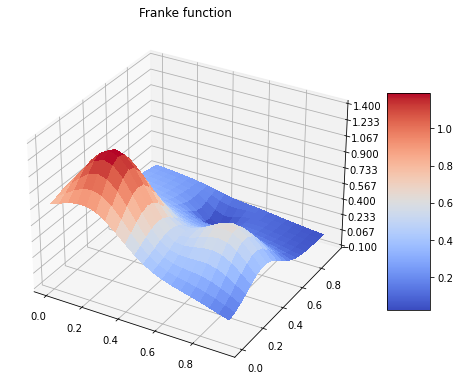

In [3]:
def plot_function(x, y, z, title=None):
    # Plot function
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the surface.
    surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

    ax.set_zlim(-0.10, 1.40)
    ax.zaxis.set_major_locator(LinearLocator(10))

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)
    if title is not None:
        plt.title(title)
    
    plt.show()
    
plot_function(x, y, z, 'Franke function')

In [4]:
def k_fold(X, y, k=[5],degree_of_polynomial=4, 
           scaling=False, solver=LinearRegression, **solver_args):
    
    
    test_mse=np.zeros((degree_of_polynomial-1, len(k)))
    
    for degree in range(1,degree_of_polynomial):
        #create pipeline for polynomial features and splitting over all polynomial degrees
        if scaling == True:
            data_model = make_pipeline(PolynomialFeatures(degree=degree), StandardScaler(with_std= True))
        else:
            data_model = make_pipeline(PolynomialFeatures(degree=degree))
        
        X_d = data_model.fit_transform(X)
        y_d = y
        
        # repeat for all k 
        for f_n, fold_f in enumerate(k ):
            # split the data into k folds
            k_fold= KFold(n_splits=fold_f)
            fold_f_mse=0.0
            #train on (fold_f-1) folds and test on the left out fold
            if solver == LinearRegression or solver == RidgeRegression or solver== Lasso:
                for nk, (train_index, test_index) in enumerate(k_fold.split(X_d)):
                    x_train, x_test = X_d[train_index], X_d[test_index]
                    y_train, y_test = y_d[train_index], y_d[test_index]
                    if solver in [LinearRegression, RidgeRegression]:
                        model = solver(**solver_args, dimension=x_train.shape)                    
                        # evaluate mse on left out fold
                        model.fit(x_train, y_train)
                        y_hat_test=model.predict(x_test)
                    else:
                        model = solver(**solver_args)
                        y_hat_test= model.fit(x_train, y_train).predict(x_test)
                    
                    mse_local = MSE(y_hat_test, y_test)
                    fold_f_mse+=mse_local

                fold_f_mse/=fold_f
            
            else:
                model= solver(**solver_args)
                fold_f_mse=-cross_val_score(model, X_d, y_d, scoring='neg_mean_squared_error', cv=fold_f)
                fold_f_mse=np.mean(fold_f_mse)
                
            test_mse[degree-1, f_n]=fold_f_mse
                      
        
    return test_mse      
    

#### Cross validation -1

Here we examine the kfold cross-validation without noise and without scaling

(9, 6)
[[0.04576671 0.03874027 0.03839682 0.03467602 0.03352505 0.03379264]
 [0.11228997 0.0684227  0.05652764 0.04264218 0.03974759 0.03686937]
 [0.01820134 0.01337367 0.01286016 0.01229501 0.01220757 0.0111079 ]
 [0.09289967 0.04102599 0.02131225 0.01729308 0.01635007 0.01698624]
 [0.13528561 0.03653383 0.02653421 0.00997742 0.00951974 0.01010605]
 [0.17236326 0.06798974 0.01740035 0.01359008 0.02610695 0.00459086]
 [1.52577331 1.13701732 0.5891621  0.42976721 0.2432325  0.15561948]
 [0.80770898 0.19879047 0.21932012 0.10383653 0.16353578 0.05521221]
 [3.62704538 0.78855081 0.0558607  0.06012734 0.02651112 0.02782034]]


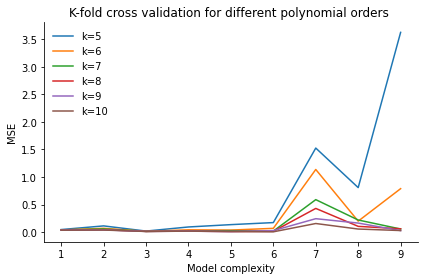

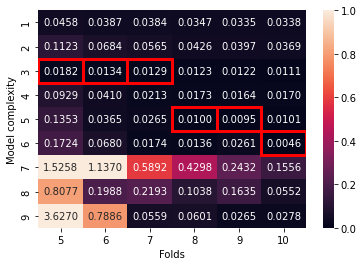

In [5]:
degree_of_polynomial= 10
k=[5, 6, 7, 8, 9, 10]

add_noise= False
if add_noise :
    np.random.seed(1)
    labels_n = labels +  np.random.normal(0 , 1, labels.shape )
else :
    labels_n = labels
    
#define the input argumets for the solver 
solver_args ={ 'fit_intercept': True }


t= k_fold(features, labels_n, k=k,degree_of_polynomial=degree_of_polynomial, 
           scaling= False, solver=LR , **solver_args)
print(t.shape)
print(t)

polynomial=np.arange(1, degree_of_polynomial)

title = 'K-fold cross validation for different polynomial orders '
plot_metric(y= t.T, x= polynomial, show= True, title=title , name='c_without_noise_without_scaling_.png', x_label='Model complexity', y_label='MSE',  save=True, legend = ['k=5','k=6', 'k=7', 'k=8', 'k=9', 'k=10'])


df = pd.DataFrame(t, index=polynomial, columns= k)
heatmap = sns.heatmap(df, vmin=0, vmax=1, annot=True, fmt=".4f",)
plt.ylabel('Model complexity')
plt.xlabel('Folds')

column_min = df.idxmin(axis=0)

for col, variable in enumerate(k):
    position = df.index.get_loc(column_min[variable])
    heatmap.add_patch(Rectangle((col, position),1,1, fill=False, edgecolor='red', lw=3))
    
fig = heatmap.get_figure()
fig.savefig(os.path.join(SAVE_PATH, 'c_heatmap_without_noise_without_scaling.png'), dpi=300, transparent=True, bbox_inches='tight')

#### Cross validation - 2

Here we examine the kfold cross-validation without noise and with scaling

(9, 6)


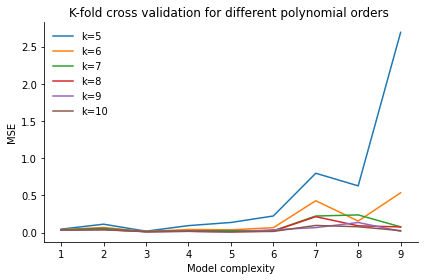

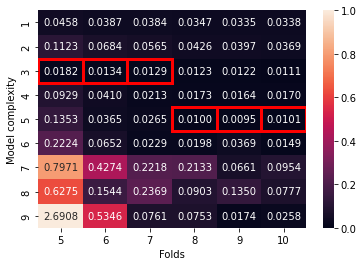

In [6]:
degree_of_polynomial= 10

k=[5, 6, 7, 8, 9, 10]

add_noise= False
if add_noise :
    np.random.seed(1)
    labels_n = labels +  np.random.normal(0 , 1, labels.shape )
else :
    labels_n = labels
    
#define the input argumets for the solver 
solver_args ={ 'fit_intercept': True }


t= k_fold(features, labels_n, k=k,degree_of_polynomial=degree_of_polynomial, 
           scaling= True, solver=LR , **solver_args)
print(t.shape)

polynomial=np.arange(1, degree_of_polynomial)
title = 'K-fold cross validation for different polynomial orders '
plot_metric(y= t.T, x= polynomial, show= True, title=title , name='c_without_noise_with_scaling_.png', x_label='Model complexity', y_label='MSE',  save=True, legend = ['k=5','k=6', 'k=7', 'k=8', 'k=9', 'k=10'])


df = pd.DataFrame(t, index=polynomial, columns= k)
heatmap = sns.heatmap(df, vmin=0, vmax=1, annot=True, fmt=".4f",)
plt.ylabel('Model complexity')
plt.xlabel('Folds')

column_min = df.idxmin(axis=0)

for col, variable in enumerate(k):
    position = df.index.get_loc(column_min[variable])
    heatmap.add_patch(Rectangle((col, position),1,1, fill=False, edgecolor='red', lw=3))
    
fig = heatmap.get_figure()
fig.savefig(os.path.join(SAVE_PATH, 'c_heatmap_without_noise_with_scaling.png'), dpi=300, transparent=True, bbox_inches='tight')

#### Cross validation -3

Here we examine the kfold cross-validation with noise and with scaling

(9, 6)
[[5.88633254e-02 5.12162753e-02 5.17400300e-02 4.76802913e-02
  4.65379264e-02 4.67767485e-02]
 [1.22886593e-01 7.90244872e-02 7.14497403e-02 5.70632334e-02
  5.36038573e-02 5.04132538e-02]
 [3.02701768e-02 2.71057859e-02 2.42511201e-02 2.30623950e-02
  2.30653026e-02 2.19154157e-02]
 [1.28987087e-01 5.71158847e-02 3.37964759e-02 2.94277362e-02
  2.80697473e-02 2.66020241e-02]
 [7.34621890e-02 3.35662692e-02 4.06959200e-02 3.58342198e-02
  2.73174393e-02 1.84767401e-02]
 [2.90268883e-01 2.23286849e-01 7.35529899e-02 3.78793339e-02
  1.19491077e-01 5.43493890e-02]
 [2.77967410e+00 5.51805482e-01 3.69018217e-01 2.87055357e-01
  1.99853968e-01 6.74820145e-02]
 [2.99301316e+01 5.87316295e+00 6.16696994e-01 6.78677311e-01
  3.90890871e-01 2.46392465e-01]
 [1.83938973e+02 6.92392659e+00 1.98532416e+00 2.10888418e+00
  1.05847565e+00 9.20021173e-01]]


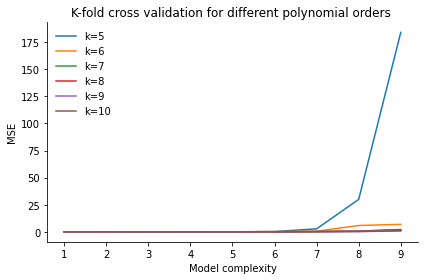

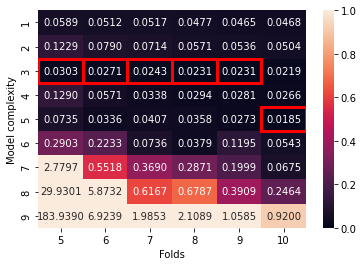

In [7]:
degree_of_polynomial= 10
k=[5, 6, 7, 8, 9, 10]

add_noise= True
if add_noise :
    np.random.seed(1)
    labels_n = labels +  np.random.normal(0 , 0.1, labels.shape )
else :
    labels_n = labels
    
#define the input argumets for the solver 
solver_args ={ 'fit_intercept': True }


t= k_fold(features, labels_n, k=k,degree_of_polynomial=degree_of_polynomial, 
           scaling= True, solver=LR , **solver_args)
print(t.shape)
print(t)

polynomial=np.arange(1, degree_of_polynomial)
title = 'K-fold cross validation for different polynomial orders '
plot_metric(y= t.T, x= polynomial, show= True, title=title , name='c_with_noise=0.1_with_scaling_.png', x_label='Model complexity', y_label='MSE',  save=True, legend = ['k=5','k=6', 'k=7', 'k=8', 'k=9', 'k=10'])


df = pd.DataFrame(t, index=polynomial, columns= k)
heatmap = sns.heatmap(df, vmin=0, vmax=1, annot=True, fmt=".4f",)
plt.ylabel('Model complexity')
plt.xlabel('Folds')

column_min = df.idxmin(axis=0)

for col, variable in enumerate(k):
    position = df.index.get_loc(column_min[variable])
    heatmap.add_patch(Rectangle((col, position),1,1, fill=False, edgecolor='red', lw=3))
    
fig = heatmap.get_figure()
fig.savefig(os.path.join(SAVE_PATH, 'c_heatmap_with_noise=0.1_with_scaling.png'), dpi=300, transparent=True, bbox_inches='tight')
    

## Compare case-3 with scikit learn implementation

(9, 6)
[[5.88633254e-02 5.12162753e-02 5.17400300e-02 4.76802913e-02
  4.65379264e-02 4.67767485e-02]
 [1.22886593e-01 7.90244872e-02 7.14497403e-02 5.70632334e-02
  5.36038573e-02 5.04132538e-02]
 [3.02701768e-02 2.71057859e-02 2.42511201e-02 2.30623950e-02
  2.30653026e-02 2.19154157e-02]
 [1.28987087e-01 5.71158847e-02 3.37964759e-02 2.94277362e-02
  2.80697473e-02 2.66020241e-02]
 [7.34621890e-02 3.35662692e-02 4.06959200e-02 3.58342198e-02
  2.73174393e-02 1.84767401e-02]
 [2.90268883e-01 2.23286849e-01 7.35529899e-02 3.78793339e-02
  1.19491077e-01 5.43493890e-02]
 [2.77967410e+00 5.51805482e-01 3.69018217e-01 2.87055357e-01
  1.99853968e-01 6.74820145e-02]
 [2.99301316e+01 5.87316295e+00 6.16696994e-01 6.78677311e-01
  3.90890871e-01 2.46392465e-01]
 [1.83938973e+02 6.92392659e+00 1.98532416e+00 2.10888418e+00
  1.05847565e+00 9.20021173e-01]]


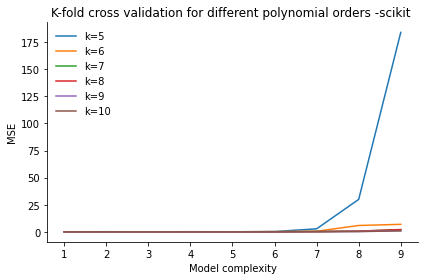

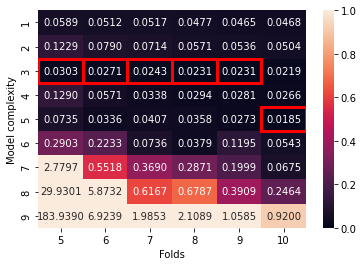

In [8]:
degree_of_polynomial= 10
k=[5, 6, 7, 8, 9, 10]

add_noise= True
if add_noise :
    np.random.seed(1)
    labels_n = labels +  np.random.normal(0 , 0.1, labels.shape )
else :
    labels_n = labels
    
#define the input argumets for the solver 
solver_args ={ 'fit_intercept': True }


t= k_fold(features, labels_n, k=k,degree_of_polynomial=degree_of_polynomial, 
           scaling= True, solver=LR, **solver_args)
print(t.shape)
print(t)

polynomial=np.arange(1, degree_of_polynomial)
title = 'K-fold cross validation for different polynomial orders -scikit '
plot_metric(y= t.T, x= polynomial, show= True, title=title , name='c_with_noise=0.1_with_scaling_scikit.png', x_label='Model complexity', y_label='MSE',  save=True, legend = ['k=5','k=6', 'k=7', 'k=8', 'k=9', 'k=10'])

df = pd.DataFrame(t, index=polynomial, columns= k)
heatmap = sns.heatmap(df, vmin=0, vmax=1, annot=True, fmt=".4f",)
plt.ylabel('Model complexity')
plt.xlabel('Folds')

column_min = df.idxmin(axis=0)

for col, variable in enumerate(k):
    position = df.index.get_loc(column_min[variable])
    heatmap.add_patch(Rectangle((col, position),1,1, fill=False, edgecolor='red', lw=3))
    
fig = heatmap.get_figure()
fig.savefig(os.path.join(SAVE_PATH, 'c_heatmap_with_noise=0.1_with_scaling_scikit.png'), dpi=300, transparent=True, bbox_inches='tight')
    

## Compare case-1 with scikit learn implementation

(9, 6)
[[0.04576671 0.03874027 0.03839682 0.03467602 0.03352505 0.03379264]
 [0.11228997 0.0684227  0.05652764 0.04264218 0.03974759 0.03686937]
 [0.01820134 0.01337367 0.01286016 0.01229501 0.01220757 0.0111079 ]
 [0.09289967 0.04102599 0.02131225 0.01729308 0.01635007 0.01698624]
 [0.13528561 0.03653383 0.02653421 0.00997742 0.00951974 0.01010605]
 [0.17236326 0.06798974 0.01740035 0.01359008 0.02610695 0.00459086]
 [1.52577331 1.13701732 0.5891621  0.42976721 0.2432325  0.15561948]
 [0.80770898 0.19879047 0.21932012 0.10383653 0.16353578 0.05521221]
 [3.62704538 0.78855081 0.0558607  0.06012734 0.02651112 0.02782034]]


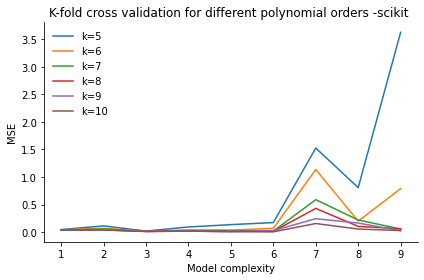

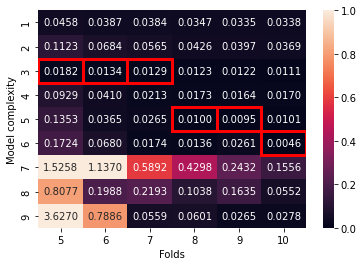

In [9]:
degree_of_polynomial= 10
k=[5, 6, 7, 8, 9, 10]

add_noise= False
if add_noise :
    np.random.seed(1)
    labels_n = labels +  np.random.normal(0 , 0.1, labels.shape )
else :
    labels_n = labels
    
#define the input argumets for the solver 
solver_args ={ 'fit_intercept': True }


t= k_fold(features, labels_n, k=k,degree_of_polynomial=degree_of_polynomial, 
           scaling= False, solver=LR, **solver_args)
print(t.shape)
print(t)

polynomial=np.arange(1, degree_of_polynomial)
title = 'K-fold cross validation for different polynomial orders -scikit '
plot_metric(y= t.T, x= polynomial, show= True, title=title , name='c_without_noise_without_scaling_scikit.png', x_label='Model complexity', y_label='MSE',  save=True, legend = ['k=5','k=6', 'k=7', 'k=8', 'k=9', 'k=10'])


df = pd.DataFrame(t, index=polynomial, columns= k)
heatmap = sns.heatmap(df, vmin=0, vmax=1, annot=True, fmt=".4f",)
plt.ylabel('Model complexity')
plt.xlabel('Folds')

column_min = df.idxmin(axis=0)

for col, variable in enumerate(k):
    position = df.index.get_loc(column_min[variable])
    heatmap.add_patch(Rectangle((col, position),1,1, fill=False, edgecolor='red', lw=3))
    
fig = heatmap.get_figure()
fig.savefig(os.path.join(SAVE_PATH, 'c_heatmap_without_noise_without_scaling_scikit.png'), dpi=300, transparent=True, bbox_inches='tight')
